# Introduction

## Dataset description
We analyze the Kaggle **US Accidents (2016–2023)** dataset and subset to **City = Miami**. Each row represents a single reported traffic incident with attributes such as ID, severity, time span, distance affected, and a coarse day/night indicator.

## Dataset link
Data source: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents


# Column selection
In the scope of this analysis we keep only the following columns (and types), dropping all others:

1. **ID** – string (bookkeeping)  
2. **Severity** – a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay). categorical (1–4)  
3. **length_hours** – length of the impact of accident on traffic flow continuous `float64` (derived as End_Time − Start_Time in hours)  
4. **Distance(mi)** – The length of the road extent affected by the accident in miles. continuous `float64` (miles)  
5. **is_day** – binary `int8` (1 = Day, 0 = Night; derived from `Sunrise_Sunset`)  
#TODO: Add one more binary

## Data transformation
- Parse `Start_Time` and `End_Time` as datetimes and compute **length_hours**.  
- Map `Sunrise_Sunset` to **is_day** (1 if "Day", else 0) and drop the original.  
- Coerce `Distance(mi)` and `length_hours` to numeric; invalid negatives are set to `NaN`.  
- Keep only `ID`, `Severity`, `length_hours`, `Distance(mi)`, `is_day`.  
- Export clean subset to `miami_accidents_prepared.csv`.


## Data manipulation
- **City filter**: Keep only rows where `City == "Miami"` (case-insensitive, trimmed).  
- **Invalid values**: Negative `length_hours` or `Distance(mi)` are set to `NaN`.  
- **Types**: Ensure `ID` is `string`, `Severity` is categorical (ordered), numerics are floats.  


In [11]:
"""
Miami Accident Data Preparation Script
--------------------------------------
Loads the US Accidents dataset, filters to Miami, cleans and processes
time and distance columns, derives day/night indicator, and saves
a compact prepared CSV for downstream analysis.

If the clean dataset already exists, it is reused.
Otherwise, it is recreated from the raw CSV.
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots render inline when running interactively
%matplotlib inline

# ---- Paths ----
csv_path = r"C:\Users\Mattan\Downloads\US_Accidents_March23.csv"  # change if needed
output_dir = os.path.abspath(".")
clean_csv_path = os.path.join(output_dir, "miami_accidents_prepared.csv")

# ---- Columns we need from the raw file ----
usecols = ["ID", "Severity", "Start_Time", "End_Time", "Distance(mi)", "City", "Sunrise_Sunset"]

# ---- Conditional Load/Rebuild ----
if os.path.exists(clean_csv_path):
    print(f"Using existing prepared file: {clean_csv_path}")
    df = pd.read_csv(clean_csv_path)
else:
    print("Prepared file not found — recreating from raw dataset...")

    # ---- Load ----
    df_raw = pd.read_csv(csv_path, usecols=usecols, low_memory=False)

    # ---- Filter to City = Miami ----
    df_raw["City"] = df_raw["City"].astype(str).str.strip()
    df_mia = df_raw[df_raw["City"].str.casefold() == "miami"].copy()

    # ---- Parse datetimes and compute length in hours ----
    df_mia["Start_Time"] = pd.to_datetime(df_mia["Start_Time"], errors="coerce")
    df_mia["End_Time"] = pd.to_datetime(df_mia["End_Time"], errors="coerce")
    df_mia["length_hours"] = (
        (df_mia["End_Time"] - df_mia["Start_Time"]).dt.total_seconds() / 3600.0
    )

    # ---- Derive is_day from Sunrise_Sunset ----
    df_mia["Sunrise_Sunset"] = df_mia["Sunrise_Sunset"].astype(str).str.strip().str.title()
    df_mia["is_day"] = (df_mia["Sunrise_Sunset"] == "Day").astype("int8")

    # ---- Keep only requested columns ----
    keep = ["ID", "Severity", "length_hours", "Distance(mi)", "is_day"]
    df = df_mia[keep].copy()

    # ---- Types & cleaning ----
    df["ID"] = df["ID"].astype("string")
    df["Severity"] = pd.Categorical(df["Severity"], ordered=True)
    df["Distance(mi)"] = pd.to_numeric(df["Distance(mi)"], errors="coerce").astype("float64")
    df["length_hours"] = pd.to_numeric(df["length_hours"], errors="coerce").astype("float64")

    # set clearly invalid values to NaN
    df.loc[df["length_hours"] < 0, "length_hours"] = np.nan
    df.loc[df["Distance(mi)"] < 0, "Distance(mi)"] = np.nan

    # ---- Save clean subset ----
    df.to_csv(clean_csv_path, index=False)
    print(f"Prepared CSV written to: {clean_csv_path}")

# ---- Show small sample ----
display(df.head(10))


Using existing prepared file: c:\Users\Mattan\Box\Documents\Technion\Courses\Semester III\970414 - Statistics II Redo\Homework\ProjEx1\miami_accidents_prepared.csv


,ID,Severity,length_hours,Distance(mi),is_day
0,A-116064,2,0.496667,0.01,1
1,A-116067,2,1.745556,0.01,1
2,A-116068,2,0.494444,0.01,1
3,A-116069,3,0.496389,0.01,1
4,A-116071,2,0.495556,0.01,1
5,A-116076,2,0.495833,0.00,1
6,A-116081,3,0.494722,0.01,0
7,A-116087,3,0.497500,0.01,0
8,A-116103,2,0.494444,0.44,0
9,A-116104,3,0.495000,0.01,0


# Preliminary Descriptive Analysis of the Data
Summary of major statistics

In [2]:
# Severity distribution
severity_counts = df['Severity'].value_counts(dropna=False).sort_index()
severity_counts

Severity
1       166
2    169909
3     14650
4      2192
Name: count, dtype: int64

In [3]:
# Day vs Night distribution
day_counts = df['is_day'].value_counts(dropna=False).rename(index={0:'Night',1:'Day'})
day_counts

is_day
Day      141979
Night     44938
Name: count, dtype: int64

In [4]:
# Numerical summaries
num_cols = ['length_hours','Distance(mi)']
desc = df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
desc

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
length_hours,156542.0,3.231809,5.931520,0.066667,0.333333,0.43,0.783333,2.016944,2.737222,12.466944,16.464886,277.931389
Distance(mi),186917.0,0.398132,0.929275,0.000000,0.000000,0.00,0.042000,0.137000,0.328000,1.583000,5.922000,23.466000


## Missing or abnormal data
- **Invalid values**: Negative `length_hours` or `Distance(mi)` were set to `NaN`.  
- **Missing values**: We summarize missingness for the kept columns below.


In [5]:
missing = df.isna().sum().to_frame('missing_count')
missing['missing_pct'] = (missing['missing_count'] / len(df)).round(4)
missing

,missing_count,missing_pct
ID,0,0.0000
Severity,0,0.0000
length_hours,30375,0.1625
Distance(mi),0,0.0000
is_day,0,0.0000


## Histogram of numerical data
For the two numerical columns, we present histograms. For highly skewed data, consider viewing with a log y-axis interactively.


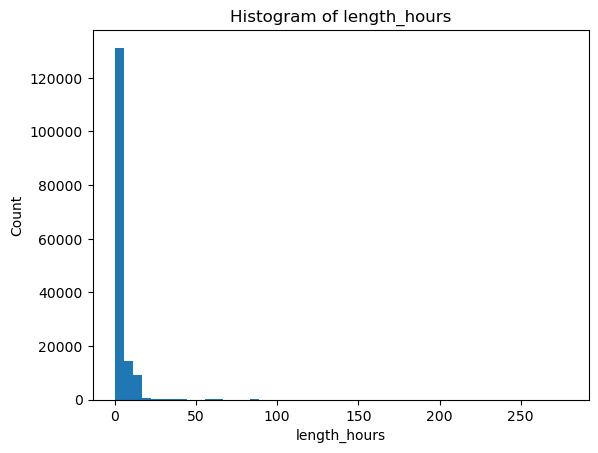

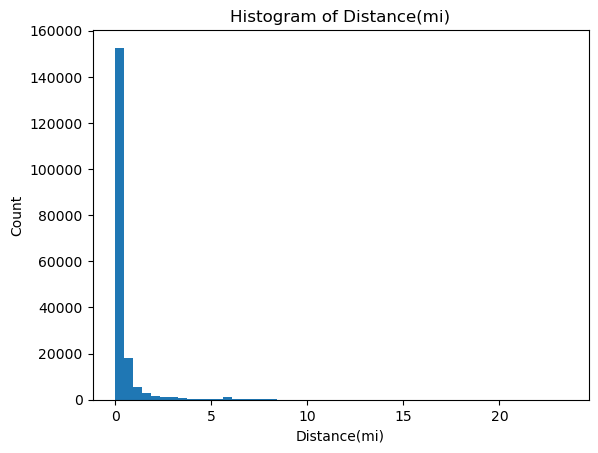

In [6]:
for col in ['length_hours','Distance(mi)']:
    plt.figure()
    df[col].dropna().plot(kind='hist', bins=50)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

## Bar plots of categorical data

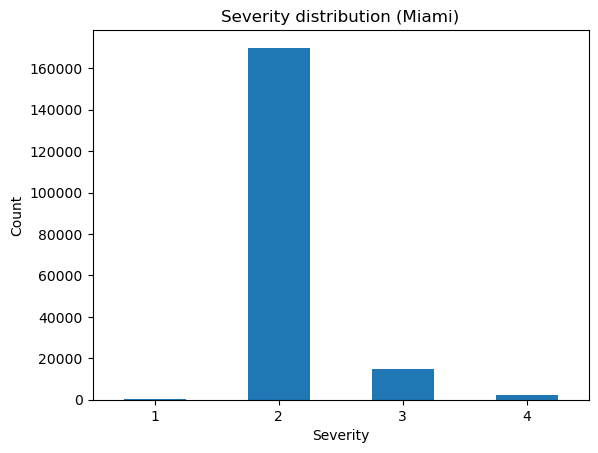

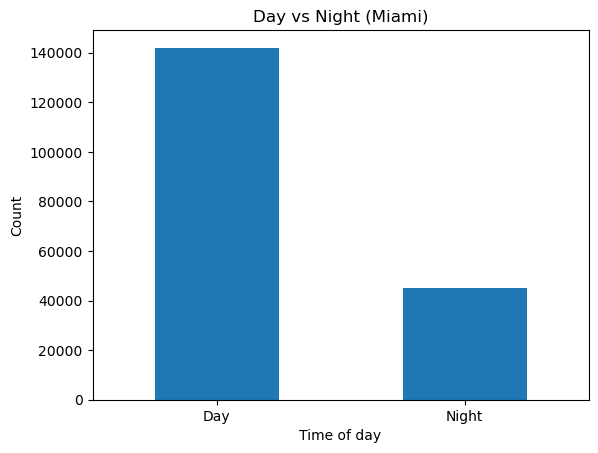

In [7]:
# Severity bar
plt.figure()
severity_counts.plot(kind='bar')
plt.title('Severity distribution (Miami)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Day vs Night bar
plt.figure()
day_counts.plot(kind='bar')
plt.title('Day vs Night (Miami)')
plt.xlabel('Time of day')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Some smart example of data visualization

**A. Distance by Severity (boxplot with cap for visibility)**

<Figure size 640x480 with 0 Axes>

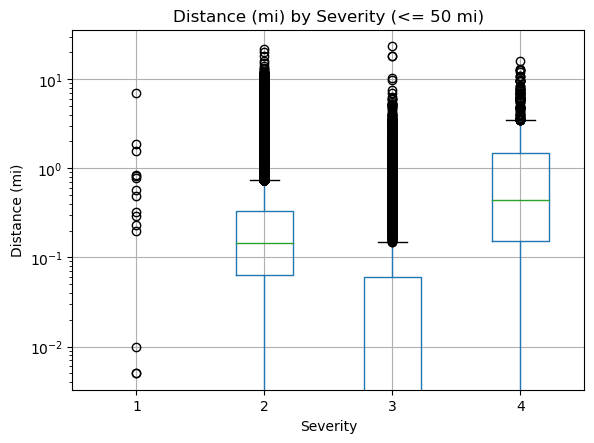

In [8]:
plot_df = df[['Severity','Distance(mi)']].dropna()
plot_df = plot_df[plot_df['Distance(mi)'] <= 50]  # cap for readability

plt.figure()
plot_df.boxplot(column='Distance(mi)', by='Severity')
plt.suptitle('')
plt.title('Distance (mi) by Severity (<= 50 mi)')
plt.xlabel('Severity')
plt.ylabel('Distance (mi)')
plt.yscale('log')
plt.show()

**B. Accident duration vs. distance (hexbin density)**

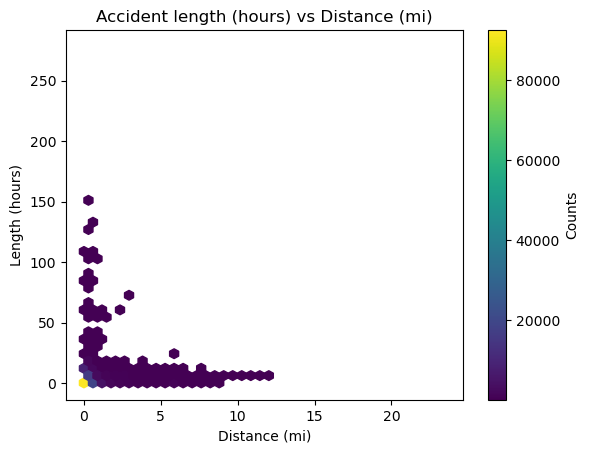

In [9]:
hex_df = df[['length_hours','Distance(mi)']].dropna()
hex_df = hex_df[hex_df['Distance(mi)'] <= 50]
plt.figure()
plt.hexbin(hex_df['Distance(mi)'], hex_df['length_hours'], gridsize=40, mincnt=5)
plt.title('Accident length (hours) vs Distance (mi)')
plt.xlabel('Distance (mi)')
plt.ylabel('Length (hours)')
cb = plt.colorbar()
cb.set_label('Counts')
plt.show()

**C. Day vs. Night differences in duration (KDE)**

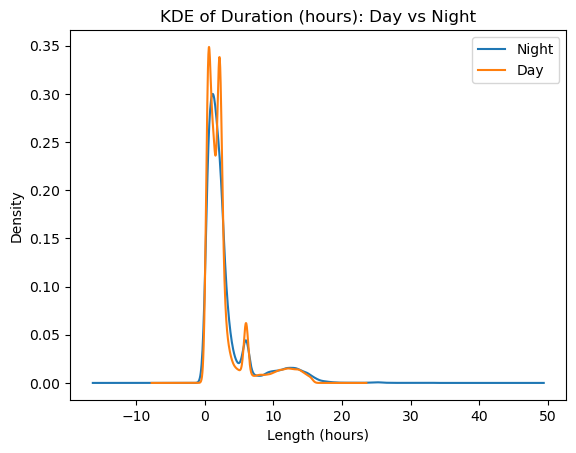

In [10]:
dur_daynight = df[['is_day','length_hours']].dropna().copy()
dur_daynight['is_day_label'] = dur_daynight['is_day'].map({1:'Day',0:'Night'})

plt.figure()
for label in ['Night','Day']:
    subset = dur_daynight[dur_daynight['is_day_label'] == label]['length_hours']
    subset = subset[(subset >= 0) & (subset <= subset.quantile(0.99))]
    subset.plot(kind='kde', label=label)

plt.title('KDE of Duration (hours): Day vs Night')
plt.xlabel('Length (hours)')
plt.legend()
plt.show()

# Research Questions
A. Does increase in distance (mi) causes increase in length_hours ?

B. **Diurnal effect**: Is nighttime (`is_day = 0`) associated with different duration/distance distributions than daytime?  

C. **Joint distribution**: How does the density of (`Distance(mi)`, `length_hours`) vary between day vs night?  